# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
from imageio import imread
# import scipy.misc
import datetime
import os
import matplotlib.pyplot as plt
import warnings
import cv2
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

#### Displaying a sample video frame for all the indexes

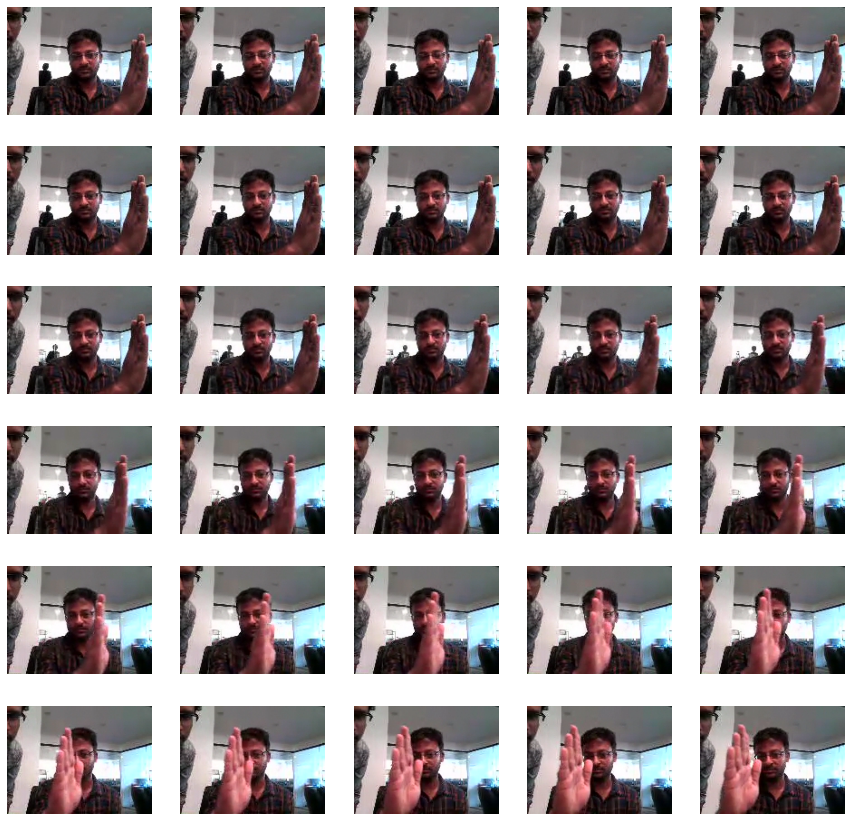

In [169]:
doc_index = 0
path = train_doc[doc_index].split(';')[0]
label_name = train_doc[doc_index].split(';')[1]
label = int(train_doc[doc_index].split(';')[2].strip('\n'))
fig = plt.figure(figsize= (15, 15))
imgs = sorted(os.listdir(source_path+path))
for i,imgPath in enumerate(imgs):
    ax = fig.add_subplot(6, 5, i+1)
    image = imread(source_path+path+'/'+imgPath)
    plt.axis('off')
    ax.imshow(image)

#### Displaying the video frame after applying selective indexes to remove redundant information

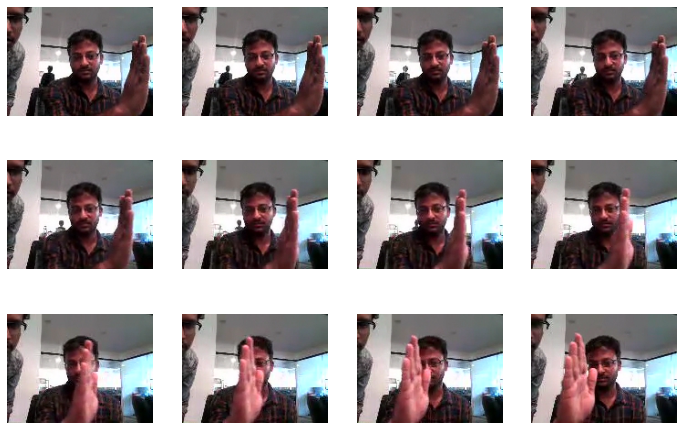

In [226]:
# If we discard intial 6 frames and last 1 frame then there are total 22 frames to consider.
# out of these 23 frames we can pick alternate frames which gives total 12 frames to pick for model
frame_idx = [a for a in range(6,29,2)]
fig = plt.figure(figsize= (12, 8))
count = 0
for i,imgPath in enumerate(imgs):
    if i in frame_idx:
        ax = fig.add_subplot(3, 4, count+1)
        image = imread(source_path+path+'/'+imgPath)
        plt.axis('off')
        ax.imshow(image)
        count += 1

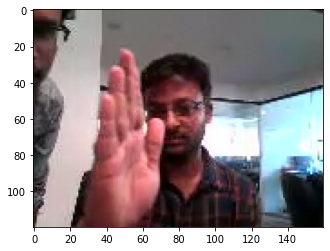

In [227]:
image = imread(source_path+path+'/'+imgs[28])
plt.imshow(image)
plt.show()

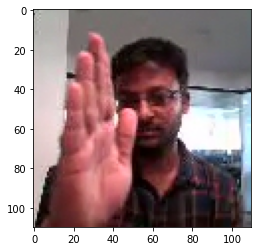

In [241]:
# After cropping the image to 110,110,3
image2 = image[10:120,20:130,:]
plt.imshow(image2)
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [a for a in range(6,29,2)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        x = len(img_idx)
        y = 110 # image length
        z = 110 # image width
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    # Cropping the image to the size of 110,110,3
                    image = image[10:120,20:130,:]
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        
        # write the code for the remaining data points which are left after full batches
        rem_batch = len(folder_list)%batch_size
        rem_batch_data = np.zeros((rem_batch,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        rem_batch_labels = np.zeros((rem_batch,5)) # batch_labels is the one hot representation of the output
        for folder in range(rem_batch): # iterate over the remaining folders of imcomplete batch
            imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*rem_batch)].split(';')[0])) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*rem_batch)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = image[10:120,20:130,:]
                rem_batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                rem_batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                rem_batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                rem_batch_labels[folder, int(t[folder + (batch*rem_batch)].strip().split(';')[2])] = 1
                
        yield rem_batch_data, rem_batch_labels
                
            
        
                


In [5]:
# Generator method with more number of input Frames
def generator2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,9,10,11,12,14,15,17,19,20,21,22,24,26,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        x = len(img_idx)
        y = 110 # image length
        z = 110 # image width
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    # Cropping the image to the size of 110,110,3
                    image = image[10:120,20:130,:]
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        
        # write the code for the remaining data points which are left after full batches
        rem_batch = len(folder_list)%batch_size
        rem_batch_data = np.zeros((rem_batch,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        rem_batch_labels = np.zeros((rem_batch,5)) # batch_labels is the one hot representation of the output
        for folder in range(rem_batch): # iterate over the remaining folders of imcomplete batch
            imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*rem_batch)].split(';')[0])) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*rem_batch)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = image[10:120,20:130,:]
                rem_batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                rem_batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                rem_batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                rem_batch_labels[folder, int(t[folder + (batch*rem_batch)].strip().split(';')[2])] = 1
                
        yield rem_batch_data, rem_batch_labels
                
            
        
                



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LeakyReLU
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

## Experiment 1 : Building a simple model using Conv3D without any regularization

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
noOfFrames = 12
height = 110
width = 110
channel = 3

In [625]:
# Adding two 3d convolution layer with 32 and 64. feature maps.
# After flattening the output of convolution added 2 dense layers of 256 neurons
model1 = Sequential()
model1.add(Conv3D(32,kernel_size=(3,3,3),activation='relu',input_shape= (noOfFrames,height,width,channel)))
model1.add(MaxPooling3D(pool_size=(2,2,2)))
model1.add(Conv3D(64,kernel_size=(3,3,3),activation='relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(5, activation='softmax'))

In [626]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print(model1.summary())

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_153 (Conv3D)         (None, 10, 108, 108, 32)  2624      
                                                                 
 max_pooling3d_95 (MaxPoolin  (None, 5, 54, 54, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_154 (Conv3D)         (None, 3, 52, 52, 64)     55360     
                                                                 
 max_pooling3d_96 (MaxPoolin  (None, 1, 26, 26, 64)    0         
 g3D)                                                            
                                                                 
 flatten_38 (Flatten)        (None, 43264)             0         
                                                                 
 dense_114 (Dense)           (None, 256)             

In [627]:
# Considering only 58 records for initial model validation experiment with batch size = 12
ablation_train = train_doc[:58]
ablation_val = val_doc[:26]
ablation_train_gen = generator(train_path,ablation_train,12)
ablation_val_gen = generator(val_path,ablation_val,12)

In [628]:
history = model1.fit(ablation_train_gen,steps_per_epoch=5,epochs=10,verbose=1,validation_data=ablation_val_gen,
          validation_steps=3)

Source path =  ./Project_data/train ; batch size = 12
Epoch 1/10


2022-09-10 15:27:37.612960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 4.7875 - categorical_accuracy: 0.2069Source path =  ./Project_data/val ; batch size = 12


2022-09-10 15:27:46.568643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 10s 2s/step - loss: 4.7875 - categorical_accuracy: 0.2069 - val_loss: 1.6494 - val_categorical_accuracy: 0.3462
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 1.5986 - categorical_accuracy: 0.3448 - val_loss: 1.6562 - val_categorical_accuracy: 0.1923
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 1.5195 - categorical_accuracy: 0.3276 - val_loss: 1.6252 - val_categorical_accuracy: 0.2692
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 1.2211 - categorical_accuracy: 0.6034 - val_loss: 1.6096 - val_categorical_accuracy: 0.2308
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 0.7865 - categorical_accuracy: 0.7586 - val_loss: 2.8402 - val_categorical_accuracy: 0.0385
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 0.6378 - categorical_accuracy: 0.8103 - val_loss: 1.9997 - val_categorical_accuracy: 0.2692
Epoch 7/10
5/5 [============================

In [67]:
def plotResults(history,epochs):
    history.history

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(range(epochs),history.history['categorical_accuracy'],label='Train accuracy')
    plt.plot(range(epochs),history.history['val_categorical_accuracy'],label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(epochs),history.history['loss'],label='Train loss')
    plt.plot(range(epochs),history.history['val_loss'],label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    

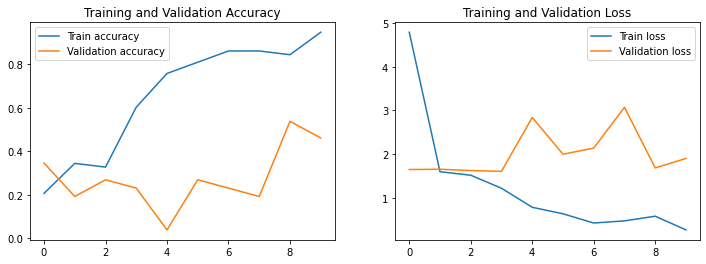

In [630]:
plotResults(history,10)

## Experiment 2 : Model1 after adding batchnormalization and dropouts

In [631]:
train_gen = generator(train_path,train_doc,32)
val_gen = generator(val_path,val_doc,32)

In [632]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [633]:
model2 = Sequential()
model2.add(Conv3D(32,kernel_size=(3,3,3),activation='relu',kernel_initializer='he_uniform',input_shape= (noOfFrames,height,width,channel)))
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.5))
model2.add(Conv3D(64,kernel_size=(3,3,3),activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(5, activation='softmax'))

In [634]:
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print(model2.summary())


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_155 (Conv3D)         (None, 10, 108, 108, 32)  2624      
                                                                 
 max_pooling3d_97 (MaxPoolin  (None, 5, 54, 54, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 5, 54, 54, 32)    216       
 chNormalization)                                                
                                                                 
 dropout_69 (Dropout)        (None, 5, 54, 54, 32)     0         
                                                                 
 conv3d_156 (Conv3D)         (None, 3, 52, 52, 64)     55360     
                                                                 
 max_pooling3d_98 (MaxPoolin  (None, 1, 26, 26, 64)  

In [635]:
history = model2.fit(ablation_train_gen,steps_per_epoch=5,epochs=10,verbose=1,validation_data=ablation_val_gen,
          validation_steps=3)

Epoch 1/10


2022-09-10 15:30:09.690947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 22.8759 - categorical_accuracy: 0.1897

2022-09-10 15:30:19.335414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 11s 2s/step - loss: 22.8759 - categorical_accuracy: 0.1897 - val_loss: 11.3771 - val_categorical_accuracy: 0.1923
Epoch 2/10
5/5 [==============================] - 10s 2s/step - loss: 8.9164 - categorical_accuracy: 0.2586 - val_loss: 45.8548 - val_categorical_accuracy: 0.1923
Epoch 3/10
5/5 [==============================] - 10s 2s/step - loss: 12.7834 - categorical_accuracy: 0.2931 - val_loss: 26.7035 - val_categorical_accuracy: 0.1538
Epoch 4/10
5/5 [==============================] - 10s 2s/step - loss: 5.2470 - categorical_accuracy: 0.4828 - val_loss: 25.5105 - val_categorical_accuracy: 0.2692
Epoch 5/10
5/5 [==============================] - 10s 2s/step - loss: 2.4562 - categorical_accuracy: 0.5517 - val_loss: 24.4800 - val_categorical_accuracy: 0.1923
Epoch 6/10
5/5 [==============================] - 10s 2s/step - loss: 3.4960 - categorical_accuracy: 0.5172 - val_loss: 25.5564 - val_categorical_accuracy: 0.1923
Epoch 7/10
5/5 [===============

## Experiment 3 : Improving model2 by adding more convolutional layer

In [688]:
model3 = Sequential()
model3.add(Conv3D(32,kernel_size=3,activation='relu',kernel_initializer='he_uniform',input_shape= (noOfFrames,height,width,channel)))
model3.add(Conv3D(32,kernel_size=3,activation='relu',kernel_initializer='he_uniform'))
model3.add(MaxPooling3D(pool_size=2))
model3.add(Conv3D(32,kernel_size=2,activation='relu',kernel_initializer='he_uniform'))
model3.add(Conv3D(64,kernel_size=2,activation='relu',kernel_initializer='he_uniform'))
model3.add(MaxPooling3D(pool_size=2))
# flatten the output
model3.add(Flatten())
model3.add(Dense(512, activation='relu',kernel_initializer='he_uniform'))
model3.add(Dropout(0.3))
model3.add(Dense(512, activation='relu',kernel_initializer='he_uniform'))
model3.add(Dropout(0.3))
model3.add(Dense(5, activation='softmax'))

In [689]:
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print(model3.summary())

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_173 (Conv3D)         (None, 10, 108, 108, 32)  2624      
                                                                 
 conv3d_174 (Conv3D)         (None, 8, 106, 106, 32)   27680     
                                                                 
 max_pooling3d_107 (MaxPooli  (None, 4, 53, 53, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_175 (Conv3D)         (None, 3, 52, 52, 32)     8224      
                                                                 
 conv3d_176 (Conv3D)         (None, 2, 51, 51, 64)     16448     
                                                                 
 max_pooling3d_108 (MaxPooli  (None, 1, 25, 25, 64)    0         
 ng3D)                                               

In [638]:
history = model3.fit(ablation_train_gen,steps_per_epoch=5,epochs=10,verbose=1,validation_data=ablation_val_gen,
          validation_steps=3)

Epoch 1/10


2022-09-10 15:33:29.261907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 76.3409 - categorical_accuracy: 0.2586

2022-09-10 15:33:46.590959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 19s 4s/step - loss: 76.3409 - categorical_accuracy: 0.2586 - val_loss: 38.6528 - val_categorical_accuracy: 0.1923
Epoch 2/10
5/5 [==============================] - 18s 4s/step - loss: 19.4838 - categorical_accuracy: 0.1897 - val_loss: 9.6951 - val_categorical_accuracy: 0.0385
Epoch 3/10
5/5 [==============================] - 18s 4s/step - loss: 11.8461 - categorical_accuracy: 0.2414 - val_loss: 4.1320 - val_categorical_accuracy: 0.2692
Epoch 4/10
5/5 [==============================] - 18s 4s/step - loss: 6.6728 - categorical_accuracy: 0.3103 - val_loss: 5.1093 - val_categorical_accuracy: 0.3077
Epoch 5/10
5/5 [==============================] - 18s 4s/step - loss: 2.7856 - categorical_accuracy: 0.3793 - val_loss: 1.7325 - val_categorical_accuracy: 0.5385
Epoch 6/10
5/5 [==============================] - 18s 4s/step - loss: 1.7535 - categorical_accuracy: 0.4483 - val_loss: 1.8703 - val_categorical_accuracy: 0.2692
Epoch 7/10
5/5 [===================

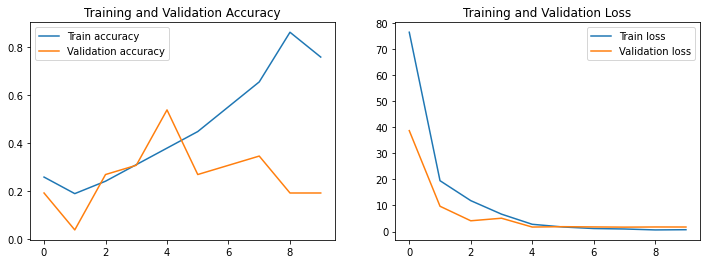

In [639]:
plotResults(history,10)

## Experiment 4: By increasing batch size to 32 and adding more records for training to model 3

In [654]:
ablation_train = train_doc[:170]
ablation_val = val_doc[:54]
ablation_train_gen = generator(train_path,ablation_train,32)
ablation_val_gen = generator(val_path,ablation_val,32)

In [655]:
history = model3.fit(ablation_train_gen,steps_per_epoch=6,epochs=10,verbose=1,validation_data=ablation_val_gen,
          validation_steps=2)

Source path =  ./Project_data/train ; batch size = 32
Epoch 1/10


2022-09-10 16:38:12.368874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 44.2638 - categorical_accuracy: 0.1824Source path =  ./Project_data/val ; batch size = 32


2022-09-10 16:38:59.249125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 50s 8s/step - loss: 44.2638 - categorical_accuracy: 0.1824 - val_loss: 8.2179 - val_categorical_accuracy: 0.1296
Epoch 2/10
6/6 [==============================] - 49s 8s/step - loss: 2.7045 - categorical_accuracy: 0.2824 - val_loss: 1.5522 - val_categorical_accuracy: 0.2593
Epoch 3/10
6/6 [==============================] - 49s 8s/step - loss: 1.4995 - categorical_accuracy: 0.2882 - val_loss: 1.5220 - val_categorical_accuracy: 0.1111
Epoch 4/10
6/6 [==============================] - 48s 8s/step - loss: 1.3644 - categorical_accuracy: 0.3588 - val_loss: 1.4857 - val_categorical_accuracy: 0.2593
Epoch 5/10
6/6 [==============================] - 49s 8s/step - loss: 1.2602 - categorical_accuracy: 0.4529 - val_loss: 1.5530 - val_categorical_accuracy: 0.2037
Epoch 6/10
6/6 [==============================] - 48s 8s/step - loss: 1.0014 - categorical_accuracy: 0.5647 - val_loss: 1.6543 - val_categorical_accuracy: 0.3148
Epoch 7/10
6/6 [======================

## Experiment 5 : Adding reduce Learning rate on plateau after every 5 epochs

In [674]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self,base_lr = 0.001,decay_epoch=1):
        super(DecayLR,self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history=[]
    def on_train_begin(self,logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
    def on_epoch_end(self,epoch,logs={}):
        if epoch % 5 == 0: # updating LR after every alternating epoch
            new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
            self.lr_history.append(tf.keras.backend.get_value(self.model.optimizer.lr))
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)    
            print('\nNew learning rate {}'.format(tf.keras.backend.get_value(self.model.optimizer.lr)))

### Changin base learning rate to 0.01

In [659]:
decay = DecayLR(base_lr=0.01)
history = model3.fit(ablation_train_gen,steps_per_epoch=6,epochs=10,verbose=1,validation_data=ablation_val_gen,
          validation_steps=2,callbacks=[decay])

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.6327 - categorical_accuracy: 0.1882
New learning rate 0.5
6/6 [==============================] - 46s 8s/step - loss: 1.6327 - categorical_accuracy: 0.1882 - val_loss: 1.5853 - val_categorical_accuracy: 0.2037
Epoch 2/10
6/6 [==============================] - 46s 8s/step - loss: 1.6327 - categorical_accuracy: 0.2000 - val_loss: 1.6263 - val_categorical_accuracy: 0.2222
Epoch 3/10
6/6 [==============================] - 46s 8s/step - loss: 1.6139 - categorical_accuracy: 0.2059 - val_loss: 1.6318 - val_categorical_accuracy: 0.2037
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 1.6261 - categorical_accuracy: 0.1588
New learning rate 0.0625
6/6 [==============================] - 47s 8s/step - loss: 1.6261 - categorical_accuracy: 0.1588 - val_loss: 1.5845 - val_categorical_accuracy: 0.1667
Epoch 5/10
6/6 [==============================] - 46s 8s/step - loss: 1.6067 - categorical_accuracy: 0.2059 - val_loss:

## Experiment 6 : Running model 3 with learning rate decay on full data and 10 epochs and batch size = 64

In [675]:
curr_dt_time = datetime.datetime.now()

In [676]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [677]:
batch_size = 64
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [678]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1)
callbacks_list = [checkpoint, LR]

In [679]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [680]:
model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 64
Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.1931 Source path =  ./Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-09-1110_32_14.357908/model-00001-1.60923-0.19306-1.60780-0.18000.h5

New learning rate 0.10000000149011612
11/11 [==============================] - 176s 16s/step - loss: 1.6092 - categorical_accuracy: 0.1931 - val_loss: 1.6078 - val_categorical_accuracy: 0.1800
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.2157 
Epoch 2: saving model to model_init_2022-09-1110_32_14.357908/model-00002-1.60956-0.21569-1.60508-0.17000.h5
11/11 [==============================] - 177s 16s/step - loss: 1.6096 - categorical_accuracy: 0.2157 - val_loss: 1.6051 - val_categorical_accuracy: 0.1700
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 1.6105 - categorical_accuracy: 0.1931 
Epoch 

## Experiment 7: Running model 3 without learning rate decay for 10 epochs on complete dataset with batch size as 32

In [681]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [682]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint]

In [683]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [686]:
model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 32
Epoch 1/10


2022-09-11 11:25:25.332380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 29.7937 - categorical_accuracy: 0.2112Source path =  ./Project_data/val ; batch size = 32


2022-09-11 11:28:22.764592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_init_2022-09-1110_32_14.357908/model-00001-29.79370-0.21116-1.70640-0.29000.h5
21/21 [==============================] - 186s 9s/step - loss: 29.7937 - categorical_accuracy: 0.2112 - val_loss: 1.7064 - val_categorical_accuracy: 0.2900
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.7534 - categorical_accuracy: 0.2066
Epoch 2: saving model to model_init_2022-09-1110_32_14.357908/model-00002-1.75338-0.20664-1.51463-0.40000.h5
21/21 [==============================] - 179s 9s/step - loss: 1.7534 - categorical_accuracy: 0.2066 - val_loss: 1.5146 - val_categorical_accuracy: 0.4000
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.4604 - categorical_accuracy: 0.3499
Epoch 3: saving model to model_init_2022-09-1110_32_14.357908/model-00003-1.46036-0.34992-1.45185-0.40000.h5
21/21 [==============================] - 190s 9s/step - loss: 1.4604 - categorical_accuracy: 0.3499 - val_loss: 1.4519 - val_categorical_accuracy: 0.4

## Experiment 8: Running for epochs = 20

In [690]:
model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2022-09-11 18:49:20.464074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 42.4518 - categorical_accuracy: 0.2112

2022-09-11 18:52:18.376883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_init_2022-09-1110_32_14.357908/model-00001-42.45179-0.21116-1.79026-0.28000.h5
21/21 [==============================] - 184s 9s/step - loss: 42.4518 - categorical_accuracy: 0.2112 - val_loss: 1.7903 - val_categorical_accuracy: 0.2800
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.7671 - categorical_accuracy: 0.3363
Epoch 2: saving model to model_init_2022-09-1110_32_14.357908/model-00002-1.76714-0.33635-1.39413-0.50000.h5
21/21 [==============================] - 182s 9s/step - loss: 1.7671 - categorical_accuracy: 0.3363 - val_loss: 1.3941 - val_categorical_accuracy: 0.5000
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4370 - categorical_accuracy: 0.4012 
Epoch 3: saving model to model_init_2022-09-1110_32_14.357908/model-00003-1.43704-0.40121-1.33852-0.45000.h5
21/21 [==============================] - 243s 12s/step - loss: 1.4370 - categorical_accuracy: 0.4012 - val_loss: 1.3385 - val_categorical_accuracy: 0

# CNN + RNN

## Experiment 1: using CNN (Conv 2d) and LSTM

In [9]:
from keras.layers import LSTM,GRU

In [742]:
# Keeping batchsize = 32
# Epochs = 20
# Running for ablation data of 170 train and 54 validation data

cnn_lstm_model = Sequential()
input_shape = (None,noOfFrames,height,width,channel)

# Adding 3 convolution 2d layer with feature maps as 16, 32 and 64. Size of kernel keeping as 3
cnn_lstm_model.add(TimeDistributed(Conv2D(16,kernel_size=3,padding='same',activation='relu',input_shape= input_shape)))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2)))        

cnn_lstm_model.add(TimeDistributed(Conv2D(32,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Conv2D(64,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(LSTM(256))

cnn_lstm_model.add(Dense(256,activation='relu'))

cnn_lstm_model.add(Dense(5,activation='softmax'))

In [743]:
cnn_lstm_model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnn_lstm_model.build(input_shape=input_shape)
cnn_lstm_model.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_101 (TimeD  (None, 12, 110, 110, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_102 (TimeD  (None, 12, 55, 55, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_103 (TimeD  (None, 12, 55, 55, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_104 (TimeD  (None, 12, 27, 27, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_105 (TimeD  (None, 12, 27, 27, 64) 

In [14]:
ablation_train = train_doc[:170]
ablation_val = val_doc[:54]
ablation_train_gen = generator(train_path,ablation_train,32)
ablation_val_gen = generator(val_path,ablation_val,32)

In [744]:
history = cnn_lstm_model.fit(ablation_train_gen, steps_per_epoch=6, epochs=20, verbose=1, validation_data=ablation_val_gen, 
                    validation_steps=2, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2022-09-12 09:55:54.830119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 09:55:55.551384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 09:55:56.816708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.7858 - categorical_accuracy: 0.2353Source path =  ./Project_data/val ; batch size = 32


2022-09-12 09:56:03.235015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 09:56:03.370815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 12s 1s/step - loss: 1.7858 - categorical_accuracy: 0.2353 - val_loss: 1.7940 - val_categorical_accuracy: 0.1481
Epoch 2/20
6/6 [==============================] - 6s 1s/step - loss: 1.6570 - categorical_accuracy: 0.2412 - val_loss: 1.5369 - val_categorical_accuracy: 0.2963
Epoch 3/20
6/6 [==============================] - 6s 1s/step - loss: 1.5139 - categorical_accuracy: 0.3059 - val_loss: 1.5980 - val_categorical_accuracy: 0.2963
Epoch 4/20
6/6 [==============================] - 5s 942ms/step - loss: 1.4822 - categorical_accuracy: 0.3882 - val_loss: 1.5091 - val_categorical_accuracy: 0.3889
Epoch 5/20
6/6 [==============================] - 6s 1s/step - loss: 1.2388 - categorical_accuracy: 0.5000 - val_loss: 1.4986 - val_categorical_accuracy: 0.3519
Epoch 6/20
6/6 [==============================] - 5s 941ms/step - loss: 0.9929 - categorical_accuracy: 0.6647 - val_loss: 1.4947 - val_categorical_accuracy: 0.3333
Epoch 7/20
6/6 [======================

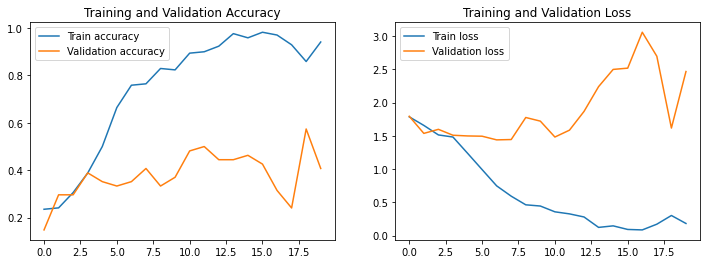

In [745]:
plotResults(history,20)

## Experiment 2 : Adding BatchNormalization and dropouts

In [32]:
cnn_lstm_model = Sequential()
input_shape = (None,noOfFrames,height,width,channel)

# Adding 3 convolution 2d layer with feature maps as 16, 32 and 64. Size of kernel keeping as 3
cnn_lstm_model.add(TimeDistributed(Conv2D(32,kernel_size=3,padding='same',activation='relu',input_shape= input_shape)))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2)))        

cnn_lstm_model.add(TimeDistributed(Conv2D(32,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Conv2D(64,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Conv2D(64,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Conv2D(128,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(LSTM(512,return_sequences=False,dropout=0.4))

cnn_lstm_model.add(Dense(512,activation='relu'))
cnn_lstm_model.add(Dropout(0.25))
cnn_lstm_model.add(Dense(512,activation='relu'))
cnn_lstm_model.add(Dropout(0.25))

cnn_lstm_model.add(Dense(5,activation='softmax'))

In [28]:
cnn_lstm_model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnn_lstm_model.build(input_shape=input_shape)
cnn_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_58 (TimeDi  (None, 12, 110, 110, 32)  896      
 stributed)                                                      
                                                                 
 batch_normalization_12 (Bat  (None, 12, 110, 110, 32)  440      
 chNormalization)                                                
                                                                 
 time_distributed_59 (TimeDi  (None, 12, 55, 55, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 12, 55, 55, 32)   9248      
 stributed)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 12, 55, 55, 32)  

In [29]:
history = cnn_lstm_model.fit(ablation_train_gen, steps_per_epoch=6, epochs=30, verbose=1, validation_data=ablation_val_gen, 
                    validation_steps=2, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


2022-09-12 12:12:43.404402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 12:12:43.980276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 12:12:44.096495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.7177 - categorical_accuracy: 0.2176

2022-09-12 12:12:51.157309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 12:12:51.392112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 10s 2s/step - loss: 1.7177 - categorical_accuracy: 0.2176 - val_loss: 1.6059 - val_categorical_accuracy: 0.1481
Epoch 2/30
6/6 [==============================] - 8s 1s/step - loss: 1.6249 - categorical_accuracy: 0.2765 - val_loss: 1.5808 - val_categorical_accuracy: 0.2593
Epoch 3/30
6/6 [==============================] - 8s 2s/step - loss: 1.6636 - categorical_accuracy: 0.2706 - val_loss: 1.5836 - val_categorical_accuracy: 0.1852
Epoch 4/30
6/6 [==============================] - 8s 2s/step - loss: 1.5344 - categorical_accuracy: 0.2941 - val_loss: 1.5852 - val_categorical_accuracy: 0.3148
Epoch 5/30
6/6 [==============================] - 8s 1s/step - loss: 1.4993 - categorical_accuracy: 0.3294 - val_loss: 1.4859 - val_categorical_accuracy: 0.2407
Epoch 6/30
6/6 [==============================] - 8s 1s/step - loss: 1.4808 - categorical_accuracy: 0.3059 - val_loss: 1.5533 - val_categorical_accuracy: 0.3148
Epoch 7/30
6/6 [============================

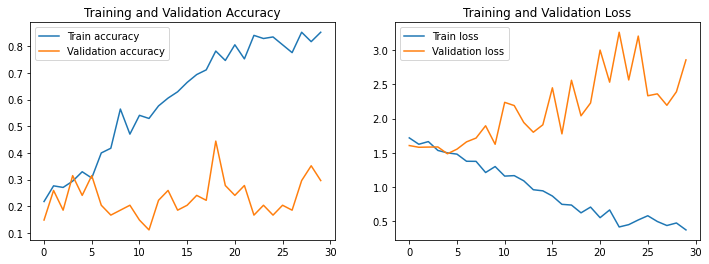

In [31]:
plotResults(history,30)

## Experiment 3: On full data + 30 epochs + ReduceLROnPlateau

In [33]:
cnn_lstm_model = Sequential()
input_shape = (None,noOfFrames,height,width,channel)

# Adding 3 convolution 2d layer with feature maps as 16, 32 and 64. Size of kernel keeping as 3
cnn_lstm_model.add(TimeDistributed(Conv2D(32,kernel_size=3,padding='same',activation='relu',input_shape= input_shape)))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2)))        

cnn_lstm_model.add(TimeDistributed(Conv2D(32,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Conv2D(64,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Conv2D(64,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Conv2D(128,kernel_size=3,padding='same',activation='relu')))
cnn_lstm_model.add(BatchNormalization(axis=3))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(2))) 

cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(LSTM(512,return_sequences=False,dropout=0.4))

cnn_lstm_model.add(Dense(512,activation='relu'))
cnn_lstm_model.add(Dropout(0.25))
cnn_lstm_model.add(Dense(512,activation='relu'))
cnn_lstm_model.add(Dropout(0.25))

cnn_lstm_model.add(Dense(5,activation='softmax'))

cnn_lstm_model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnn_lstm_model.build(input_shape=input_shape)
cnn_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_69 (TimeDi  (None, 12, 110, 110, 32)  896      
 stributed)                                                      
                                                                 
 batch_normalization_17 (Bat  (None, 12, 110, 110, 32)  440      
 chNormalization)                                                
                                                                 
 time_distributed_70 (TimeDi  (None, 12, 55, 55, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 12, 55, 55, 32)   9248      
 stributed)                                                      
                                                                 
 batch_normalization_18 (Bat  (None, 12, 55, 55, 32)  

In [10]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
history = cnn_lstm_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 32
Epoch 1/20


2022-09-12 13:04:58.331306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 13:04:59.089500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 13:04:59.293612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.6367 - categorical_accuracy: 0.2821Source path =  ./Project_data/val ; batch size = 32


2022-09-12 13:05:21.553630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-12 13:05:21.849543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_init_2022-09-1213_03_44.035175/model-00001-1.63670-0.28205-1.56546-0.28000.h5
21/21 [==============================] - 28s 1s/step - loss: 1.6367 - categorical_accuracy: 0.2821 - val_loss: 1.5655 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5346 - categorical_accuracy: 0.2926
Epoch 2: saving model to model_init_2022-09-1213_03_44.035175/model-00002-1.53460-0.29261-1.77723-0.24000.h5
21/21 [==============================] - 24s 1s/step - loss: 1.5346 - categorical_accuracy: 0.2926 - val_loss: 1.7772 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4704 - categorical_accuracy: 0.3665
Epoch 3: saving model to model_init_2022-09-1213_03_44.035175/model-00003-1.47035-0.36652-1.93276-0.20000.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 23s 1s/ste

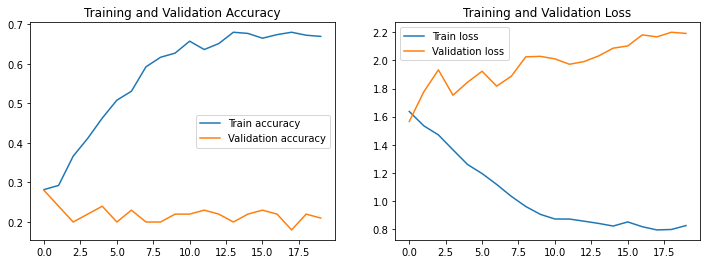

In [38]:
plotResults(history,20)

## Experiment 4: Using resnet architecture to convolve the features then using LSTM

In [30]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [40]:
resnet = ResNet50(weights='imagenet',input_shape=(height,width,channel),include_top = False)

In [32]:
input_shape = (noOfFrames,height,width,channel)
model_resnet = Sequential()
model_resnet.add(TimeDistributed(resnet,input_shape=input_shape))
# Fixing the pretrained weights for resnet
for layer in model_resnet.layers:
    layer.trainable = False

# Adding 2 convolution layer of filter size 32 and 64 feature maps 
model_resnet.add(TimeDistributed(Conv2D(32,kernel_size=3,padding='same',activation='relu')))
model_resnet.add(TimeDistributed(Conv2D(64,kernel_size=3,padding='same',activation='relu')))

model_resnet.add(TimeDistributed(BatchNormalization(axis=3)))
model_resnet.add(TimeDistributed(MaxPooling2D(2))) 

model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Dropout(0.3))
model_resnet.add(LSTM(256,return_sequences=False,dropout=0.4))
# Adding 2 fully connected layers with 256 neurons
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dropout(0.2))

model_resnet.add(Dense(5,activation='softmax'))

model_resnet.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_resnet.build(input_shape=input_shape)
model_resnet.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 12, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 12, 4, 4, 32)     589856    
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 12, 4, 4, 64)     18496     
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 12, 4, 4, 64)     256       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 12, 2, 2, 64)    

In [33]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [34]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
history = model_resnet.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 32
Epoch 1/10


2022-09-13 09:07:44.333429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 09:07:45.569023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 09:07:46.216865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.6553 - categorical_accuracy: 0.1825Source path =  ./Project_data/val ; batch size = 32


2022-09-13 09:08:13.942471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 09:08:14.782521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_init_2022-09-1309_07_25.592691/model-00001-1.65528-0.18250-1.61320-0.21000.h5
21/21 [==============================] - 37s 2s/step - loss: 1.6553 - categorical_accuracy: 0.1825 - val_loss: 1.6132 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.6226 - categorical_accuracy: 0.2097
Epoch 2: saving model to model_init_2022-09-1309_07_25.592691/model-00002-1.62262-0.20965-1.62010-0.22000.h5
21/21 [==============================] - 32s 2s/step - loss: 1.6226 - categorical_accuracy: 0.2097 - val_loss: 1.6201 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.6168 - categorical_accuracy: 0.2293
Epoch 3: saving model to model_init_2022-09-1309_07_25.592691/model-00003-1.61680-0.22926-1.62641-0.23000.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 32s 2s/ste

## Experiment 5 : Using 18 pictures from every video instead of 12 and using 64 batch size. Using mobilenet model

In [21]:
from keras import backend as k
def clearModel(model):
    k.clear_session()
    del model
    

In [10]:
from tensorflow.keras.applications import mobilenet

In [11]:
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

Metal device set to: Apple M1


2022-09-13 10:06:24.166879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-13 10:06:24.167234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


17225924/17225924 [==============================] - 11s 1us/step


In [64]:
noOfFrames = 18
input_shape = (noOfFrames,height,width,channel)
model_mobile = Sequential()
model_mobile.add(TimeDistributed(mobilenet_model,input_shape=input_shape))
# Fixing the pretrained weights for resnet
for layer in model_mobile.layers:
    layer.trainable = False


model_mobile.add(TimeDistributed(BatchNormalization(axis=3)))
model_mobile.add(TimeDistributed(MaxPooling2D(2))) 

model_mobile.add(TimeDistributed(Flatten()))
model_mobile.add(Dropout(0.5))
model_mobile.add(LSTM(128))
model_mobile.add(Dropout(0.5))
model_mobile.add(Dense(128,activation='relu'))
model_mobile.add(Dropout(0.5))

model_mobile.add(Dense(5,activation='softmax'))

model_mobile.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_mobile.build(input_shape=input_shape)
model_mobile.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 18, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 dropout_6 (Dropout)         (None, 18, 1024)         

In [61]:
batch_size = 64
train_generator = generator2(train_path, train_doc, batch_size)
val_generator = generator2(val_path, val_doc, batch_size)

In [62]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [65]:
history = model_mobile.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2022-09-13 11:28:36.879935: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_20 in the registry.
Traceback (most recent call last):

  File "/Users/vivektrivedi/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_20 in the registry.


2022-09-13 11:28:36.880444: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_20 in the registry.
Traceback (most recent call last):

  File "/Users/vivektrivedi/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError:

11/11 [==============================] - ETA: 0s - loss: 1.7120 - categorical_accuracy: 0.2247Source path =  ./Project_data/val ; batch size = 64


2022-09-13 11:29:03.640571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 11:29:04.209282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_init_2022-09-1311_27_54.315600/model-00001-1.71196-0.22474-1.53435-0.37000.h5
11/11 [==============================] - 33s 3s/step - loss: 1.7120 - categorical_accuracy: 0.2247 - val_loss: 1.5343 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.4987 - categorical_accuracy: 0.3363
Epoch 2: saving model to model_init_2022-09-1311_27_54.315600/model-00002-1.49871-0.33635-1.41513-0.50000.h5
11/11 [==============================] - 30s 3s/step - loss: 1.4987 - categorical_accuracy: 0.3363 - val_loss: 1.4151 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.3751 - categorical_accuracy: 0.4103
Epoch 3: saving model to model_init_2022-09-1311_27_54.315600/model-00003-1.37509-0.41026-1.22929-0.56000.h5
11/11 [==============================] - 31s 3s/step - loss: 1.3751 - categorical_accuracy: 0.4103 - val_loss: 1.2293 - val_cate

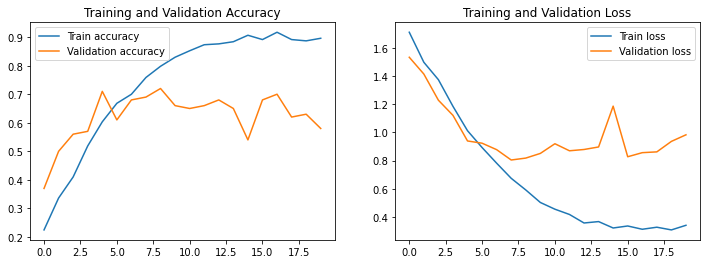

In [68]:
plotResults(history,20)

## Experiment 6 : Using GRU

In [74]:
noOfFrames = 18
input_shape = (noOfFrames,height,width,channel)
model_mobile = Sequential()
model_mobile.add(TimeDistributed(mobilenet_model,input_shape=input_shape))
# Fixing the pretrained weights for resnet
for layer in model_mobile.layers:
    layer.trainable = False


model_mobile.add(TimeDistributed(BatchNormalization(axis=3)))
model_mobile.add(TimeDistributed(MaxPooling2D(2))) 

model_mobile.add(TimeDistributed(Flatten()))
model_mobile.add(Dropout(0.5))
model_mobile.add(GRU(256))
model_mobile.add(Dropout(0.5))
model_mobile.add(Dense(256,activation='relu'))
model_mobile.add(Dropout(0.5))

model_mobile.add(Dense(5,activation='softmax'))

model_mobile.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_mobile.build(input_shape=input_shape)
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 18, 1024)          0

In [75]:
history = model_mobile.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2022-09-13 11:59:28.133842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 11:59:29.176333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 11:59:30.312135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.7959 - categorical_accuracy: 0.3092

2022-09-13 11:59:56.007567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 11:59:56.824967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_init_2022-09-1311_27_54.315600/model-00001-1.79587-0.30920-1.39904-0.35000.h5
11/11 [==============================] - 36s 3s/step - loss: 1.7959 - categorical_accuracy: 0.3092 - val_loss: 1.3990 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.3724 - categorical_accuracy: 0.4615
Epoch 2: saving model to model_init_2022-09-1311_27_54.315600/model-00002-1.37236-0.46154-1.25175-0.54000.h5
11/11 [==============================] - 32s 3s/step - loss: 1.3724 - categorical_accuracy: 0.4615 - val_loss: 1.2517 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.1343 - categorical_accuracy: 0.5626
Epoch 3: saving model to model_init_2022-09-1311_27_54.315600/model-00003-1.13429-0.56259-1.01876-0.62000.h5
11/11 [==============================] - 32s 3s/step - loss: 1.1343 - categorical_accuracy: 0.5626 - val_loss: 1.0188 - val_cate

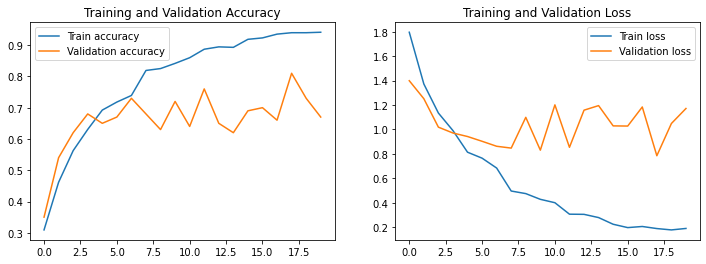

In [76]:
plotResults(history,20)